In [4]:
import requests
import pandas as pd
import datetime
import time
import random
import re
import spacy
import yfinance as yf

In [37]:
from bs4 import BeautifulSoup
from dateutil.relativedelta import relativedelta
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from matplotlib import pyplot as plt

In [30]:
nlp = spacy.load('en_core_web_sm')
analyzer = SentimentIntensityAnalyzer()

# Scraping news dataset

In [6]:
def scrape_news(query, start_date, end_date, max_entries = 5):
    """
    Scrapes news articles from Google News RSS for a given query and filters them by data.

    Parameters:
        query(str): the stock or company name to search for.
        start_date(date): the start date for filtering articles.
        end_date(date): the end date for filtering articles.
        max_entries(int): number of times to retry incase of request failure.

    returns:
        pd.DataFrame: a dataframe consisting of article title, link, and publication date
    """
    articles = []
    url = f"https://news.google.com/rss/search?q={query}+after:{start_date}+before:{end_date}"
    for i in range(max_entries):
        try:
            response = requests.get(url)
            break
        except exception as e:
            print(f"an error occured in requesting {e}")
            print(f"retrying attempt {i}")
            time.sleep(random.uniform(2,10))
        
    soup = BeautifulSoup(response.content, 'xml')
    items = soup.find_all('item')
    
    for item in items:
        title = item.title.text
        link = item.link.text
        pub_date = item.pubDate.text
        articles.append({'title': title, 'link': link, 'pub_date': pub_date})
    return pd.DataFrame(articles)

In [7]:
def scrape_news_over_date_range(query, start_date, end_date):
    """
    Scrapes news articles over a given date range by iterating through months.

    Parameters:
        query(str): The stock or company name to search for.
        start_date(str): the start date in 'yyyy-mm-dd' format.
        end_date(str): the end date in 'yyyy-mm-dd' format.

    Returns:
        pd.DataFrame: A DataFrame collected across the date range.
    """
    start_date_dt = datetime.datetime.strptime(start_date, '%Y-%m-%d').date()
    end_date_dt = datetime.datetime.strptime(end_date, '%Y-%m-%d').date()

    all_articles = pd.DataFrame()

    current_date = start_date_dt

    while current_date<end_date_dt:
        next_date = min(current_date + relativedelta(months = 1), end_date_dt)
        
        start_str = current_date.strftime('%Y-%m-%d')
        end_str = next_date.strftime('%Y-%m-%d')
        month_articles = scrape_news(query, start_str, end_str)
        all_articles = pd.concat([all_articles, month_articles], ignore_index=True)
        current_date = next_date

    return all_articles    

In [8]:
def scrape_and_save_news(queries, start_date, end_date):
    """
    Scrapes news articles for mutliple queries over a gives date range and saves each result to a csv file

    Parameters:
        queries(list): A list of stock or company names to search for.
        start_date(str): the start date in 'yyyy-mm-dd' format.
        end_date(str): the end date in 'yyyy-mm-dd' format.

    Outputs:
        CSV files named after each query, containing scraped news articles.
    """
    for query in queries:
        articles = scrape_news_over_date_range(query, start_date, end_date)
        output_csv = f"{query}.csv"
        articles.to_csv(output_csv, index=False)
        print(f"Saved {query} articles to {output_csv}")

In [32]:
queries = ["Reliance", "Microsoft", "Google"]
start_date = '2020-01-01'
end_date = '2022-12-31'
scrape_and_save_news(queries, start_date, end_date)

Saved Reliance articles to Reliance.csv
Saved Microsoft articles to Microsoft.csv
Saved Google articles to Google.csv


In [9]:
news_df1 = pd.read_csv('Reliance.csv')
news_df2 = pd.read_csv('Microsoft.csv')
news_df3 = pd.read_csv('Google.csv')

# Pre-Processing

In [10]:
def clean_text(text: str):
    """
    Cleans the text and returns in form of tokens.

    Parameters:
    text(str): string to be cleaned.

    Returns:
    str: a joint of tokens created.
    """
    text = text.lower()
    doc = nlp(text.lower())

    tokens = [token.lemma_ for token in doc 
             if not token.is_stop 
             and not token.is_punct 
             and token.text not in ["'", '"']]

    return ' '.join(tokens)

In [11]:
news_df1['cleaned_text'] = news_df1['title'].apply(clean_text)
news_df2['cleaned_text'] = news_df2['title'].apply(clean_text)
news_df2['cleaned_text'] = news_df2['title'].apply(clean_text)

# Extracting Stock Prices for supervised training

In [12]:
start_date = '2022-01-01'
end_date = '2022-12-31'

stock_symbols = {'Reliance': 'RELIANCE.NS', 'Microsoft': 'MSFT', 'Google': 'GOOGL'}

date_range = pd.date_range(start = start_date, end = end_date, freq = 'B') # 'B' for business days

def fetch_stock_data(symbol:str, max_entries =3):
    """
    fetches stock data from yahoo.

    Parameters:
    symbol(str): symbol corresponding to the country name.
    max_entries(int): no. of retries in fetching if the fetch fails.

    Returns: 
    pd.DataFrame: dataset containing stockprices
    """
    for i in range(max_entries):
        try:
            stock_data = yf.download(symbol, start= start_date, end= end_date)
        except Exception as e:
            print (f'error fetching data {e}; retrying attempt {i}.....')
        time.sleep(random.uniform(2,5))

        return stock_data

In [104]:
for company, symbol in stock_symbols.items():
    stock_data = fetch_stock_data(symbol)
    stock_data.reset_index(inplace = True)
    output_csv = f'{company}_stock_prices.csv'
    stock_data.to_csv(output_csv, index = False)
    print(f"stock_price for {company} saved")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

stock_price for Reliance saved



[*********************100%***********************]  1 of 1 completed

stock_price for Microsoft saved


stock_price for Google saved


In [19]:
stock_df1 = pd.read_csv('Reliance_stock_prices.csv')
stock_df2 = pd.read_csv('Microsoft_stock_prices.csv')
stock_df3 = pd.read_csv('Google_stock_prices.csv')

# Sentiment Scores

In [32]:
news_df1['sentiment'] = news_df1['cleaned_text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
news_df2['sentiment'] = news_df1['cleaned_text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
news_df3['sentiment'] = news_df1['cleaned_text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# Merging the needed dataset

In [52]:
def merge_data(news_df:pd.DataFrame, stock_df:pd.DataFrame, company:str):
    """
    Merge the news dataframe with stock prices dataframe for every company

    Parametes:
        news_df(pd.DataFrame): dataframe containing the features.
        stock_df(pd.DataFrame): dataframe containing the the stock prices
        company(str): company to which the dataframes belong to.

    Output:
        Saves csv file of merged pdf under the name  "merged_data_{company}.csv".
    """
    news_df['pub_date'] = pd.to_datetime(news_df['pub_date']).dt.date
    stock_df['Date'] = pd.to_datetime(news_df['pub_date']).dt.date

    merged_df = pd.merge(news_df, stock_df, left_on = 'pub_date', right_on = 'Date', how = 'inner')

    output_csv = f'merged_data_{company}.csv'
    merged_df.to_csv(output_csv, index = False)
    print(f"merged data for company: {company}")

In [34]:
merge_data(news_df1, stock_df1, 'Reliance')
merge_data(news_df2, stock_df2, 'Microsoft')
merge_data(news_df3, stock_df3, 'Google')

merged data for company: Reliance
merged data for company: Microsoft
merged data for company: Google


In [35]:
df1 = pd.read_csv('merged_data_Reliance.csv')
df2 = pd.read_csv('merged_data_Microsoft.csv')
df3 = pd.read_csv('merged_data_Google.csv')

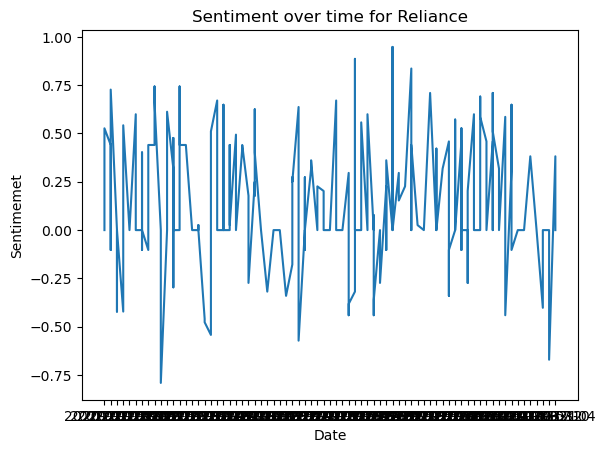

<Figure size 10000x500 with 0 Axes>

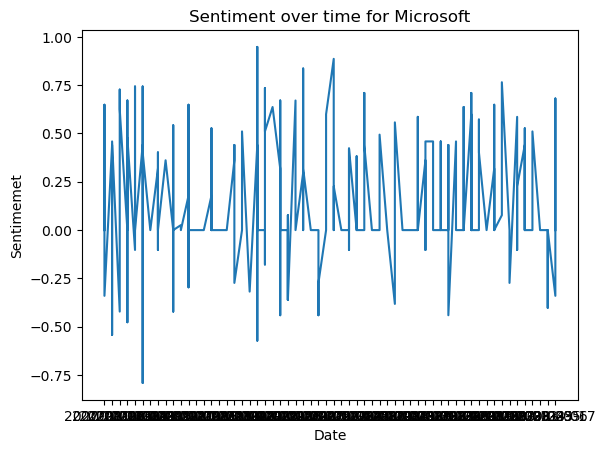

<Figure size 10000x500 with 0 Axes>

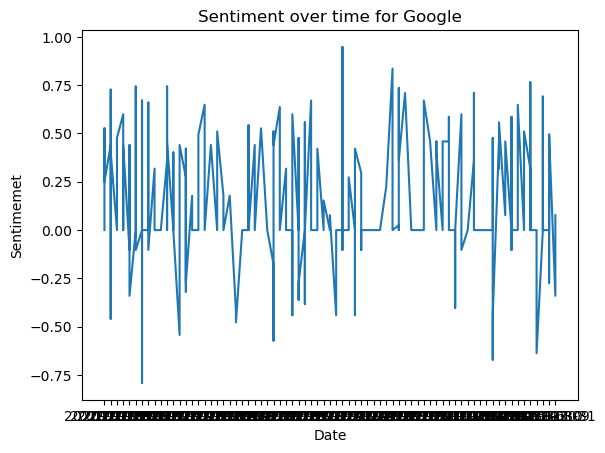

<Figure size 10000x500 with 0 Axes>

In [51]:
queries = {'Reliance': df1, 'Microsoft': df2, 'Google': df3}
for query, df in queries.items():
    plt.plot(df['Date'], df['sentiment'])
    plt.title(f'Sentiment over time for {query}')
    plt.xlabel('Date')
    plt.ylabel('Sentimemet')
    plt.figure(figsize = (100,5))
    plt.show()
   

In [53]:
df.columns

Index(['title', 'link', 'pub_date', 'sentiment', 'Date', 'Close', 'High',
       'Low', 'Open', 'Volume'],
      dtype='object')

# Getting the labels

In [90]:
def calculate_price_movement(df: pd.DataFrame, condition: str):
    """
    Adds a new column to the DataFrame indicating stock price movement over a specified time period.

    Parameters:
        df (pd.DataFrame): A DataFrame containing merged stock and news data.
        condition (str): Specifies the time period for price change calculation.
            - 'daily': Price change over one day.
            - 'weekly': Price change over one week.
            - 'monthly': Price change over one month.

    Returns:
        pd.DataFrame: The updated DataFrame with a new column "{conditon}_movement" representing price movement.
    """
    
    df['Date'] = pd.to_datetime(df['Date']).dt.date
    df = df.sort_values(by = 'Date')

    if condition =='daily':
        df['daily_movement'] =  None
        last_price = {}
        for i in range(len(df)):
            current_date= df.loc[i, 'Date']
            current_price = df.loc[i, 'Close']
            last_date = max([d for d in last_price.keys() if d<current_date], default = None)
            if last_date:
                df.loc[i, 'daily_movement'] = (
                    'increase' if current_price>last_price[last_date] else
                    'decrease' if current_price<last_price[last_date] else
                    'same'
                ) 
            last_price[current_date] = current_price
    elif condition == 'weekly':
        df['weekly_movement'] = None
        last_week_end = None

        for week_start in sorted(df['Date'].unique()):
            week_end = week_start+pd.Timedelta(days = 6)
            past_week_prices = df[(df['Date']>=last_week_end) & (df['Date']<week_start)]['Close']
            new_week_prices = df[(df['Date']>=week_start) & (df['Date']<=week_end)]['Close']

            if not past_week_prices.empty and not new_week_prices.empty:
                past_week_price = past_week_prices.iloc[-1]
                new_week_price = new_week_prices.iloc[-1]

                df.loc[df['Date']==week_start, 'weekly_movement'] = (
                    'increase' if new_week_price>past_week_price else
                    'decrease' if new_week_price<past_week_price else
                    'same'
                )
            last_week_end = week_end
            
    elif condition == 'monthly':
        df['monthly_movement'] = None
        last_month_end = None
        for month_start in sorted(df['Date'].unique()):
            month_end = month_start + relativedelta(months=1)-pd.Timedelta(days=1)
            past_month_prices = df[(df['Date']>=last_month_end) & (df['Date']< month_start)]['Close']
            new_month_prices = df[(df['Date']>=month_start) & (df['Date']<=month_end)]['Close']

            if not past_month_prices.empty and not new_month_prices.empty:
                past_month_price = past_month_prices.iloc[-1]
                new_month_price = new_month_prices.iloc[-1]

                df.loc[df['Date']==week_start, 'monthly_movement'] = (
                    'increase' if past_month_price<new_month_price else
                    'decrease' if past_month_price>new_month_price else
                    'same'
                )
            last_month_end = month_end
    else:
        raise ValueError(f"Invalid condition '{condition}'. Expected one of these: ['daily', 'weekly', 'monthly'].")
        return
    return df
        

In [91]:
df_daily1 = calculate_price_movement(df1, 'daily').dropna(subset=['daily_movement'], inplace=True)
df_daily2 = calculate_price_movement(df2, 'daily').dropna(subset=['daily_movement'], inplace=True)
df_daily3 = calculate_price_movement(df3, 'daily').dropna(subset=['daily_movement'], inplace=True)

In [92]:
df_weekly1 = calculate_price_movement(df1, 'weekly').dropna(subset = ['weekly_movement'], inplace = True) 
df_weekly2 = calculate_price_movement(df2, 'weekly').dropna(subset = ['weekly_movement'], inplace = True) 
df_weekly3 = calculate_price_movement(df3, 'weekly').dropna(subset = ['weekly_movement'], inplace = True) 

In [94]:
df_monthly1 = calculate_price_movement(df1, 'monthly').dropna(subset=['monthly_movement'], inplace = True)
df_monthly2 = calculate_price_movement(df2, 'monthly').dropna(subset=['monthly_movement'], inplace = True)
df_monthly3 = calculate_price_movement(df3, 'monthly').dropna(subset=['monthly_movement'], inplace = True)

# Feature Extraction